In [1]:
!pip install git+https://github.com/openai/CLIP.git --quiet

  Preparing metadata (setup.py) ... done


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from tqdm import tqdm
import os
import random
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import InterpolationMode
from PIL import Image
import io
from collections import OrderedDict
from typing import Tuple, Union

from clip import clip
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer

import math

In [4]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [5]:
_tokenizer = _Tokenizer()

In [6]:
# # batch_first=False --> the expected input format is (sequence_length, batch_size, embedding_dim)
# # batch_first= True --> the expected input format is (batch_size, sequence_length, embedding_dim)

# class ContextAttention(nn.Module):
#     def __init__(self, embed_dim, image_dim, num_heads, dtype):
#         super(ContextAttention, self).__init__()
#         self.attention_layer = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True).to(dtype)
#         self.img_projection = nn.Linear(image_dim, embed_dim).to(dtype)

#     def forward(self, image_features, ctx_features):
#         """
#         Args:
#             image_features: Tensor of shape [b, 196, 768] (batch size, seq length, feature size)
#             ctx_feature: Tensor of shape [b, n_ctx, 512]
#         Returns:
#             Tensor of shape [b, n_ctx, 512] containing attended context features.
#         """
#         device = 'cuda' if torch.cuda.is_available() else 'cpu'
#         ctx_features = ctx_features.to(device)

#         image_features = self.img_projection(image_features).to(device) # shape = (b, 196, 512)

#         attn_output, attn_weight = self.attention_layer(ctx_features, image_features, image_features)

#         return attn_output, attn_weight # attn_output shape is (b, n_ctx, 512)

In [7]:
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts):

        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)


        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), [tokenized_prompts.argmax(dim=-1)]*x.shape[0]] @ self.text_projection

        # tokenized_prompts has shape [77]
        # tokenized_prompts.argmax(dim=-1) will give list i.e; [19]



        return x

In [8]:
class PromptLearner(nn.Module):
    def __init__(self, cfg, classnames, clip_model, image_dim):
        super().__init__()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        n_cls = len(classnames)
        n_ctx = cfg.TRAINER.COOP.N_CTX
        ctx_init = cfg.TRAINER.COOP.CTX_INIT
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]
        clip_imsize = clip_model.visual.input_resolution
        cfg_imsize = cfg.INPUT.SIZE[0]
        assert cfg_imsize == clip_imsize, f"cfg_imsize ({cfg_imsize}) must equal to clip_imsize ({clip_imsize})"

        if ctx_init:
            # use given words to initialize context vectors
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(" "))
            prompt = clip.tokenize(ctx_init).to(device)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
            prompt_prefix = ctx_init

        else:
            # random initialization
            if cfg.TRAINER.COOP.CSC:
                print("Initializing class-specific contexts")
                ctx_vectors = torch.empty(n_cls, n_ctx, ctx_dim, dtype=dtype, device = device)
            else:
                print("Initializing a generic context")
                ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype, device = device)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        self.ctx = nn.Parameter(ctx_vectors)  # to be optimized

        classnames = [name.replace("_", " ") for name in classnames]
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [prompt_prefix + " " + name + "." for name in classnames]

        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)

        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # CLS, EOS

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens
        self.class_token_position = cfg.TRAINER.COOP.CLASS_TOKEN_POSITION

        self.img_projection = nn.Linear(image_dim, ctx_dim).to(dtype)
        self.ctx_attn = nn.MultiheadAttention(embed_dim=ctx_dim, num_heads=4, batch_first=True, dropout=0.3).to(dtype)
        self.ctx_norm1 = nn.LayerNorm(ctx_dim).to(dtype)
        self.ctx_norm2 = nn.LayerNorm(ctx_dim).to(dtype)


    def forward(self, image_features):
        ctx = self.ctx  # (n_cls, n_ctx, dim)
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)


        ctx1 = ctx[0].unsqueeze(0).expand(image_features.shape[0], -1, -1) # (b, n_ctx, dim)
        ctx2 = ctx[1].unsqueeze(0).expand(image_features.shape[0], -1, -1) # (b, n_ctx, dim)


        projected_image_features = self.img_projection(image_features) # (b, 196, dim)
        ctx_attn_output1, ctx_attn_weight1 = self.ctx_attn(ctx1, projected_image_features, projected_image_features)
        ctx1 = ctx1 + ctx_attn_output1
        ctx1 = self.ctx_norm1(ctx1)

        ctx_attn_output2, ctx_attn_weight2 = self.ctx_attn(ctx2, projected_image_features, projected_image_features)
        ctx2 = ctx2 + ctx_attn_output2
        ctx2 = self.ctx_norm2(ctx2)


        prefix1 = self.token_prefix[0] # (1, dim) ----> shape of self.token_prefix = (n_cls, 1, dim)
        suffix1 = self.token_suffix[0] # (*, dim) ----> shape of self.token_prefix = (n_cls, *, dim)
        prefix2 = self.token_prefix[1] # (1, dim)
        suffix2 = self.token_suffix[1] # (*, dim)


        prefix1 = prefix1.unsqueeze(0).expand(image_features.shape[0], -1, -1) # (b, 1, dim)
        suffix1 = suffix1.unsqueeze(0).expand(image_features.shape[0], -1, -1) # (b, *, dim)
        prefix2 = prefix2.unsqueeze(0).expand(image_features.shape[0], -1, -1) # (b, 1, dim)
        suffix2 = suffix2.unsqueeze(0).expand(image_features.shape[0], -1, -1) # (b, *, dim)


        prompts1 = torch.cat(
                            [prefix1, # (b, 1, dim)
                             ctx1,    # (b, n_ctx, dim)
                             suffix1  # (b, *, dim)
                            ], dim=1 )

        prompts2 = torch.cat(
                            [prefix2, # (b, 1, dim)
                             ctx2,    # (b, n_ctx, dim)
                             suffix2  # (b, *, dim)
                            ], dim=1 )


        return prompts1, prompts2

In [9]:
class MultiscaleAdapter(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.branch_f = nn.Sequential(
            nn.Conv2d(input_dim, input_dim, kernel_size=1, padding=0, dilation=1),
            #nn.BatchNorm2d(input_dim),
            nn.LayerNorm([input_dim, 14, 14]),
            #nn.ReLU()
            nn.GELU()
        )
        self.branch_g = nn.Sequential(
            nn.Conv2d(input_dim, input_dim, kernel_size=3, padding=3, dilation=3),
            #nn.BatchNorm2d(input_dim),
            nn.LayerNorm([input_dim, 14, 14]),
            #nn.ReLU()
            nn.GELU()
        )
        self.branch_h = nn.Sequential(
            nn.Conv2d(input_dim, input_dim, kernel_size=5, padding=10, dilation=5),
            #nn.BatchNorm2d(input_dim),
            nn.LayerNorm([input_dim, 14, 14]),
            #nn.ReLU()
            nn.GELU()
        )

        # Combine features and project back to original dimension
        self.combine = nn.Sequential(
            nn.Conv2d(input_dim * 3, input_dim, kernel_size=1),
            #nn.BatchNorm2d(input_dim),
            nn.LayerNorm([input_dim, 14, 14]),
            #nn.ReLU(),
            nn.GELU(),
            nn.Dropout(p=0.3)
        )

        self.weight_f = nn.Parameter(torch.ones(1))
        self.weight_g = nn.Parameter(torch.ones(1))
        self.weight_h = nn.Parameter(torch.ones(1))

        self.se_block = nn.Sequential(
                        nn.AdaptiveAvgPool2d(1),
                        nn.Conv2d(input_dim, input_dim // 4, kernel_size=1),
                        nn.LayerNorm([input_dim // 4, 1, 1]),
                        nn.GELU(),
                        nn.Conv2d(input_dim // 4, input_dim, kernel_size=1),
                        nn.LayerNorm([input_dim, 1, 1]),
                        nn.Sigmoid()
                    )


    def forward(self, x):
        # x.shape = (32, 768, 196)
        x = x.unsqueeze(2)
        # Now x.shape =  torch.Size([32, 768, 1, 196])
        x = x.reshape(x.shape[0], x.shape[1], int(math.sqrt(x.shape[3])), int(math.sqrt(x.shape[3])))
        # x.shape =  torch.Size([32, 768, 14, 14])
        x_f = self.branch_f(x)
        x_g = self.branch_g(x)
        x_h = self.branch_h(x)
        # Concatenate along channel dimension and project back
        # x_out = torch.cat([x_f, x_g, x_h], dim=1)
        x_out = torch.cat([self.weight_f * x_f, self.weight_g * x_g, self.weight_h * x_h], dim=1)
        x_out = self.combine(x_out) # shape = [32, 768, 14, 14]
        #x_out = x_out * self.se_block(x_out)
        x_out = x_out.reshape(x_out.shape[0], x_out.shape[1], -1) # shape = [32, 768, 196]
        return x_out

In [10]:
class CustomCLIP(nn.Module):
    def __init__(self, cfg, classnames, clip_model):
        super().__init__()
        self.image_encoder = clip_model.visual
        image_dim = self.image_encoder.ln_post.weight.shape[0]
        text_dim = clip_model.token_embedding.weight.shape[1]
        self.dtype = clip_model.dtype
        self.prompt_learner = PromptLearner(cfg, classnames, clip_model, image_dim)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.patch_embedding = self.image_encoder.conv1
        self.class_embedding = self.image_encoder.class_embedding
        self.positional_embedding = self.image_encoder.positional_embedding
        self.ln_pre = self.image_encoder.ln_pre
        self.ln_post = self.image_encoder.ln_post
        self.patch_norm1 = nn.LayerNorm(image_dim).to(self.dtype)
        self.patch_norm2 = nn.LayerNorm(image_dim).to(self.dtype)

        self.text_encoder = TextEncoder(clip_model)
        self.multiscale_adapters = nn.ModuleList(
                                    [MultiscaleAdapter(input_dim=image_dim).to(self.dtype)
                                    for _ in range(len(self.image_encoder.transformer.resblocks))]
                                  )
        self.patch_attn = nn.MultiheadAttention(embed_dim=image_dim, num_heads=4, batch_first=True, dropout=0.3).to(self.dtype)
        self.image_cls_proj = self.image_encoder.proj
        self.logit_scale = clip_model.logit_scale

    def forward(self, images):
        x = self.patch_embedding(images.type(self.dtype))  # (32, 768, 14, 14)
        x = x.reshape(x.shape[0], x.shape[1], -1).permute(0, 2, 1)  # (batch, num_patches, embed_dim) i.e; (32, 196, 768)
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)
        num_layers = len(self.image_encoder.transformer.resblocks)




        for i, block in enumerate(self.image_encoder.transformer.resblocks):
            x = x.permute(1, 0, 2) # shape = [197, 32, 768]
            x = block(x) # shape = [197, 32, 768]
            x = x.permute(1, 0, 2) # shape = [32, 197, 768]
            # if i < (num_layers - 1):
            # if i in [6, 7, 8, 9, 10]:
            if i in [7, 8, 9, 10]:
              x_cls = x[:, 0] # shape = [32, 768]
              x_cls = x_cls.unsqueeze(1) # shape = [32, 1, 768]
              x_patches = x[:, 1:] # shape = [32, 196, 768]
              x_patches = x_patches.permute(0, 2, 1) # shape = [32, 768, 196]
              x_patches_msa = self.multiscale_adapters[i](x_patches) # shape = [32, 768, 196]
              x_patches_msa = x_patches_msa.permute(0, 2, 1) # shape = [32, 196, 768]
              x_patches = x_patches.permute(0, 2, 1) # shape = [32, 196, 768]
              x_patches = self.patch_attn(x_patches_msa, x_patches, x_patches)[0] + x_patches
              x_patches = self.patch_norm1(x_patches)
              x = torch.cat([x_cls, x_patches], dim=1) # shape = [32, 197, 768]


        image_patches = x[:, 1:] # shape = [32, 196, 768]

        promptlearner_output1, promptlearner_output2  = self.prompt_learner(image_patches)
        # shape of each promptlearner_output --> [32, 77, 512]

        text_features1 = self.text_encoder(promptlearner_output1, self.tokenized_prompts[0]) # shape = [32, 512]
        text_features2 = self.text_encoder(promptlearner_output2, self.tokenized_prompts[1]) # shape = [32, 512]



        image_cls = x[:, 0] # shape = [32, 768]
        image_cls = self.ln_post(image_cls) # shape = [32, 768]
        image_cls = image_cls @ self.image_cls_proj # shape = [32, 512]
        image_cls = image_cls.unsqueeze(1) # shape = [32, 1, 512]


        image_cls = image_cls / image_cls.norm(dim=-1, keepdim=True)
        text_features1 = text_features1 / text_features1.norm(dim=-1, keepdim=True)
        text_features2 = text_features2 / text_features2.norm(dim=-1, keepdim=True)

        text_features = torch.stack([text_features1, text_features2], dim=1) # shape = [32, 2, 512]

        text_features = text_features.permute(0, 2, 1) # shape = [32, 512, 2]


        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_cls @ text_features
        logits = logits.squeeze(1) # (32, 2)

        return logits

# **Training**

In [11]:
# Custom function to simulate compression artifacts
def compress_blur(image):
    # Save the image temporarily in JPEG format to simulate compression
    buffer = io.BytesIO()  # Create an in-memory byte buffer
    image.save(buffer, format="JPEG", quality=75)  # Adjust quality as needed for stronger compression
    buffer.seek(0)  # Move to the start of the buffer
    return Image.open(buffer)

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BICUBIC),
    transforms.RandomResizedCrop(224),  # Random crop within (224, 224)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Lambda(lambda img: compress_blur(img)),  # Apply compression blur simulation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation= InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]),
])

In [12]:
data_dir = '/content/drive/MyDrive/Zero_Shot_DeepFake_Image_Classification/CLIP_based_deepfake_detection/dataset/F2F'

# Load the dataset
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
train_dataset.class_to_idx = {'real': 0, 'fake': 1}
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=test_transform)
val_dataset.class_to_idx = {'real': 0, 'fake': 1}

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers= os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers= os.cpu_count())

In [13]:
def train_model(model, train_loader, val_loader, device, num_epochs=8, lr=0.001, print_freq=125): # 0.001
    model.train()

    optimizer = optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr,
        momentum=0.9,
        weight_decay=1e-4
    )

    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.00001)

    criterion = nn.CrossEntropyLoss()


    for epoch in range(num_epochs):

        if (epoch+1) == 4:
          break
        running_loss = 0.0
        correct = 0
        total = 0


        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate: {scheduler.get_last_lr()[0]}")


        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Training")):

            images, labels = images.to(device), labels.to(device)

            logits = model(images)

            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            # Gradient clipping
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if (batch_idx + 1) % print_freq == 0:
                batch_loss = loss.item()
                batch_acc = (predicted == labels).sum().item() / labels.size(0)
                print(f"Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {batch_loss:.4f}, Accuracy: {batch_acc:.4f}")

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total
    val_acc = correct / total
    return val_loss, val_acc

In [14]:
class Config:
    def __init__(self):
        # General Trainer configuration
        self.TRAINER = TrainerConfig()
        # Input configuration (image size, etc.)
        self.INPUT = InputConfig()

class TrainerConfig:
    def __init__(self):
        # COOP-specific settings
        self.COOP = CoopConfig()

class CoopConfig:
    def __init__(self):
        # Number of context words in the prompt
        self.N_CTX = 64  # This can be changed as needed #16
        # Initial prompt context, set to None if random initialization is desired
        #self.CTX_INIT = "This photo is"  # Initial context string
        self.CTX_INIT = None
        # Whether to use class-specific contexts
        self.CSC = True  # Set True if you want class-specific contexts
        # Position of the class token in the prompt (e.g., "front", "middle", "end")
        self.CLASS_TOKEN_POSITION = "end"

class InputConfig:
    def __init__(self):
        # Image size expected by the model (e.g., 224 for 224x224 images)
        self.SIZE = [224]  # Ensure this matches the CLIP model input size

# Instantiate the configuration
cfg = Config()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model, preprocess = clip.load("ViT-B/16", device=device)

# clip_model = clip_model.float()

classnames = ["pristine", "forged"]

model = CustomCLIP(cfg = cfg, classnames=classnames, clip_model=clip_model).to(device)

Initializing class-specific contexts
Initial context: "X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X"
Number of context words (tokens): 64


In [16]:
for name, param in model.named_parameters():
  if all(keyword not in name for keyword in [ "prompt_learner", "multiscale_adapters", "patch_norm1", "patch_norm2", "patch_attn"]):
    param.requires_grad_(False)
# prompt_learner, multiscale_adapters, patch_norm, patch_attn --> requires grad

In [17]:
train_model(model, train_loader, val_loader, device)

Epoch 1/8, Learning Rate: 0.000962320368593087

Epoch 1/8


Training:  13%|█▎        | 126/1000 [01:44<02:05,  6.98it/s]

Batch [125/1000], Loss: 0.6821, Accuracy: 0.6250


Training:  25%|██▌       | 251/1000 [02:02<01:47,  6.94it/s]

Batch [250/1000], Loss: 0.6885, Accuracy: 0.4375


Training:  38%|███▊      | 376/1000 [02:20<01:28,  7.04it/s]

Batch [375/1000], Loss: 0.7271, Accuracy: 0.4375


Training:  50%|█████     | 501/1000 [02:38<01:10,  7.05it/s]

Batch [500/1000], Loss: 0.6685, Accuracy: 0.6875


Training:  63%|██████▎   | 626/1000 [02:56<00:55,  6.79it/s]

Batch [625/1000], Loss: 0.6914, Accuracy: 0.5000


Training:  75%|███████▌  | 751/1000 [03:14<00:35,  6.93it/s]

Batch [750/1000], Loss: 0.7246, Accuracy: 0.3750


Training:  88%|████████▊ | 876/1000 [03:31<00:17,  7.02it/s]

Batch [875/1000], Loss: 0.6724, Accuracy: 0.6250


Training: 100%|██████████| 1000/1000 [03:49<00:00,  4.35it/s]

Batch [1000/1000], Loss: 0.5903, Accuracy: 0.6250


Epoch [1/8], Train Loss: 0.6795, Train Accuracy: 0.5513, Val Loss: 0.6717, Val Accuracy: 0.5515
Epoch 2/8, Learning Rate: 0.000855017856687341

Epoch 2/8


Training:  13%|█▎        | 126/1000 [00:18<02:03,  7.06it/s]

Batch [125/1000], Loss: 0.5562, Accuracy: 0.8750


Training:  25%|██▌       | 251/1000 [00:36<01:48,  6.92it/s]

Batch [250/1000], Loss: 0.5571, Accuracy: 0.7500


Training:  38%|███▊      | 376/1000 [00:54<01:29,  6.98it/s]

Batch [375/1000], Loss: 0.5752, Accuracy: 0.6250


Training:  50%|█████     | 501/1000 [01:12<01:12,  6.88it/s]

Batch [500/1000], Loss: 0.5596, Accuracy: 0.7500


Training:  63%|██████▎   | 626/1000 [01:30<00:54,  6.91it/s]

Batch [625/1000], Loss: 0.4937, Accuracy: 0.7500


Training:  75%|███████▌  | 751/1000 [01:48<00:35,  7.09it/s]

Batch [750/1000], Loss: 0.4785, Accuracy: 0.8125


Training:  88%|████████▊ | 876/1000 [02:06<00:17,  7.07it/s]

Batch [875/1000], Loss: 0.5659, Accuracy: 0.6250


Training: 100%|██████████| 1000/1000 [02:24<00:00,  6.93it/s]

Batch [1000/1000], Loss: 0.4722, Accuracy: 0.8125


Epoch [2/8], Train Loss: 0.5484, Train Accuracy: 0.7133, Val Loss: 0.4593, Val Accuracy: 0.7590
Epoch 3/8, Learning Rate: 0.0006944282990207195

Epoch 3/8


Training:  13%|█▎        | 126/1000 [00:19<02:04,  7.05it/s]

Batch [125/1000], Loss: 0.5132, Accuracy: 0.7500


Training:  25%|██▌       | 251/1000 [00:36<01:46,  7.06it/s]

Batch [250/1000], Loss: 0.2651, Accuracy: 0.8750


Training:  38%|███▊      | 376/1000 [00:55<01:29,  6.98it/s]

Batch [375/1000], Loss: 0.6260, Accuracy: 0.7500


Training:  50%|█████     | 501/1000 [01:12<01:11,  6.95it/s]

Batch [500/1000], Loss: 0.5811, Accuracy: 0.7500


Training:  63%|██████▎   | 626/1000 [01:30<00:53,  7.05it/s]

Batch [625/1000], Loss: 0.3687, Accuracy: 0.6875


Training:  75%|███████▌  | 751/1000 [01:48<00:36,  6.86it/s]

Batch [750/1000], Loss: 0.3196, Accuracy: 0.8750


Training:  88%|████████▊ | 876/1000 [02:06<00:17,  7.05it/s]

Batch [875/1000], Loss: 0.4888, Accuracy: 0.6875


Training: 100%|██████████| 1000/1000 [02:24<00:00,  6.92it/s]

Batch [1000/1000], Loss: 0.4058, Accuracy: 0.8125


Epoch [3/8], Train Loss: 0.4266, Train Accuracy: 0.7968, Val Loss: 0.2694, Val Accuracy: 0.8895


# **Testing**

In [18]:
# Define the testing function
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()  # Loss function for testing

    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient tracking
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)


            logits = model(images)
            loss = criterion(logits, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Collect true labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics
    test_loss = running_loss / total
    test_acc = correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Generate and display the confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# **CELEB-Test**

In [19]:
dir = '/content/drive/MyDrive/Zero_Shot_DeepFake_Image_Classification/CLIP_based_deepfake_detection/dataset/CELEB'
test_dataset = datasets.ImageFolder(root=os.path.join(dir, 'test'), transform=test_transform)
test_dataset.class_to_idx = {'real': 0, 'fake': 1}
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers= os.cpu_count())

Test Loss: 0.6625, Test Accuracy: 0.6460


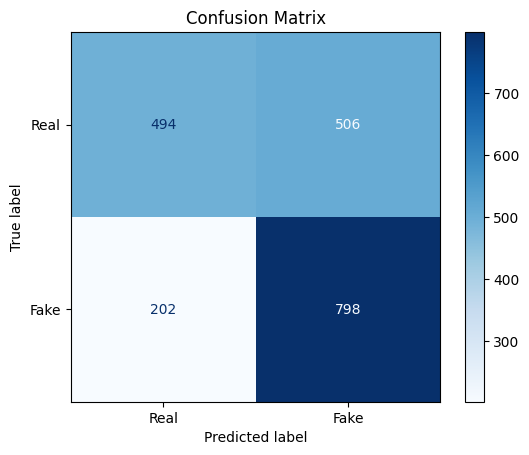

In [20]:
# Test the model after training
test_model(model, test_loader, device)

# **FS**

In [21]:
dir = '/content/drive/MyDrive/Zero_Shot_DeepFake_Image_Classification/CLIP_based_deepfake_detection/dataset/FS'
test_dataset = datasets.ImageFolder(root=os.path.join(dir, 'test'), transform=test_transform)
test_dataset.class_to_idx = {'real': 0, 'fake': 1}
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers= os.cpu_count())

Test Loss: 0.7042, Test Accuracy: 0.6675


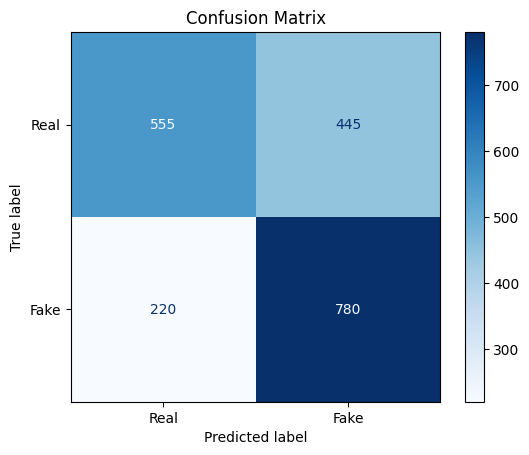

In [22]:
# Test the model after training
test_model(model, test_loader, device)

# **NT**

In [23]:
dir = '/content/drive/MyDrive/Zero_Shot_DeepFake_Image_Classification/CLIP_based_deepfake_detection/dataset/NT'
test_dataset = datasets.ImageFolder(root=os.path.join(dir, 'test'), transform=test_transform)
test_dataset.class_to_idx = {'real': 0, 'fake': 1}
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers= os.cpu_count())

Test Loss: 0.8324, Test Accuracy: 0.6080


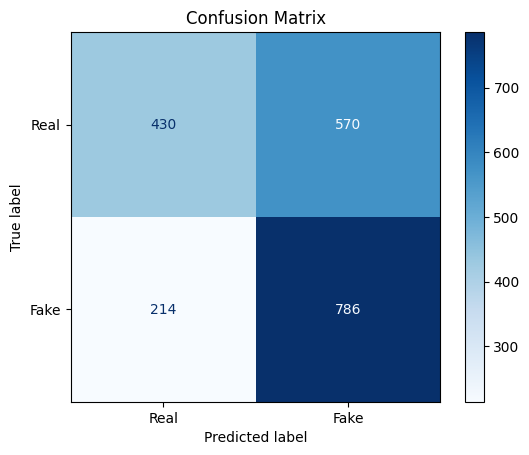

In [24]:
# Test the model after training
test_model(model, test_loader, device)

# **DF**

In [25]:
dir = '/content/drive/MyDrive/Zero_Shot_DeepFake_Image_Classification/CLIP_based_deepfake_detection/dataset/DF'
test_dataset = datasets.ImageFolder(root=os.path.join(dir, 'test'), transform=test_transform)
test_dataset.class_to_idx = {'real': 0, 'fake': 1}
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers= os.cpu_count())

Test Loss: 0.5158, Test Accuracy: 0.7555


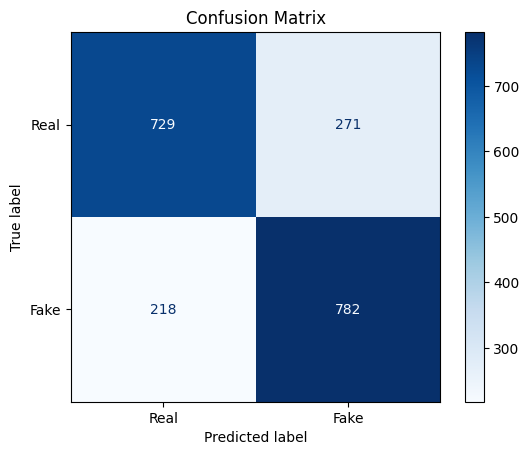

In [26]:
# Test the model after training
test_model(model, test_loader, device)

# **DFD**

In [27]:
dir = '/content/drive/MyDrive/Zero_Shot_DeepFake_Image_Classification/CLIP_based_deepfake_detection/dataset/DFD'
test_dataset = datasets.ImageFolder(root=os.path.join(dir, 'test'), transform=test_transform)
test_dataset.class_to_idx = {'real': 0, 'fake': 1}
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers= os.cpu_count())

Test Loss: 0.7206, Test Accuracy: 0.6345


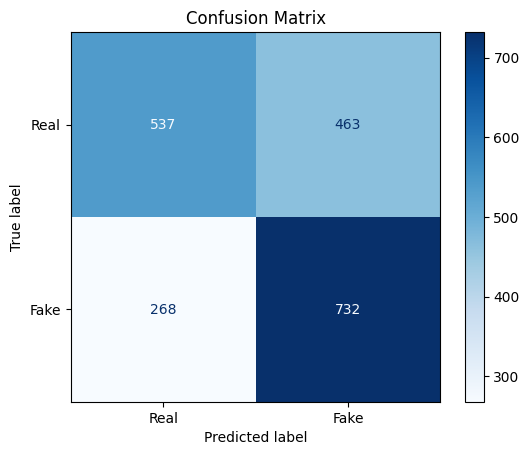

In [28]:
# Test the model after training
test_model(model, test_loader, device)

# **F2F**

In [29]:
dir = '/content/drive/MyDrive/Zero_Shot_DeepFake_Image_Classification/CLIP_based_deepfake_detection/dataset/F2F'
test_dataset = datasets.ImageFolder(root=os.path.join(dir, 'test'), transform=test_transform)
test_dataset.class_to_idx = {'real': 0, 'fake': 1}
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers= os.cpu_count())

Test Loss: 0.2956, Test Accuracy: 0.8715


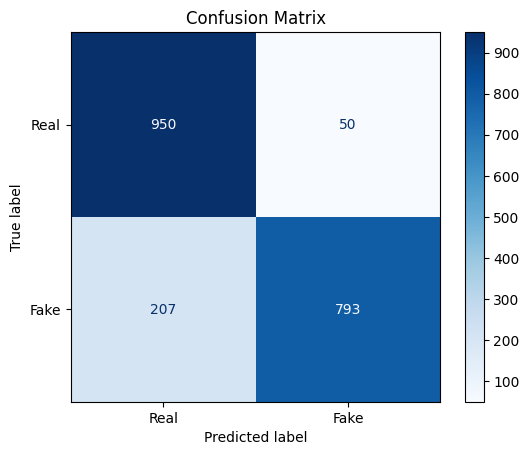

In [30]:
# Test the model after training
test_model(model, test_loader, device)